# scores in function of token overlap


In [32]:
import os
import json
import math
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

f1 = {"ner": "eval_f1", "copa": "eval_acc", "pos": "eval_f1_macro", "qa": "f1", "sib": "eval_accuracy"}
tasks = f1.keys()
scores = {task: {} for task in tasks}
inf = math.inf
# From huggingface api, with our trained adapters (eu, sr)
existing_adapters = [
    "th",
    "my",
    "hi",
    "ilo",
    "ht",
    "tr",
    "mi",
    "vi",
    "is",
    "it",
    "ta",
    "jv",
    "ja",
    "sw",
    "qu",
    "de",
    "el",
    "et",
    "ru",
    "gn",
    "id",
    "en",
    "ar",
    "es",
    "tk",
    "zh",
    "mhr",
    "cdo",
    "xmf",
    "eu",
    "sr",
]
# scraped from cc-100 website
xlm_included_langs = [
    "af",
    "am",
    "ar",
    "as",
    "az",
    "be",
    "bg",
    "bn",
    "br",
    "bs",
    "ca",
    "cs",
    "cy",
    "da",
    "de",
    "el",
    "en",
    "eo",
    "es",
    "et",
    "eu",
    "fa",
    "ff",
    "fi",
    "fr",
    "fy",
    "ga",
    "gd",
    "gl",
    "gn",
    "gu",
    "ha",
    "he",
    "hi",
    "hr",
    "ht",
    "hu",
    "hy",
    "id",
    "ig",
    "is",
    "it",
    "ja",
    "jv",
    "ka",
    "kk",
    "km",
    "kn",
    "ko",
    "ku",
    "ky",
    "la",
    "lg",
    "li",
    "ln",
    "lo",
    "lt",
    "lv",
    "mg",
    "mk",
    "ml",
    "mn",
    "mr",
    "ms",
    "my",
    "ne",
    "nl",
    "no",
    "ns",
    "om",
    "or",
    "pa",
    "pl",
    "ps",
    "pt",
    "qu",
    "rm",
    "ro",
    "ru",
    "sa",
    "si",
    "sc",
    "sd",
    "sk",
    "sl",
    "so",
    "sq",
    "sr",
    "ss",
    "su",
    "sv",
    "sw",
    "ta",
    "te",
    "th",
    "tl",
    "tn",
    "tr",
    "ug",
    "uk",
    "ur",
    "uz",
    "vi",
    "wo",
    "xh",
    "yi",
    "yo",
    "zu",
    "zh",
]

for file in os.listdir("../eval_scores/selected"):
    if file.endswith(".json"):
        try:
            with open(os.path.join("../eval_scores/selected", file), "r") as f:
                data = json.load(f)
                task_name = file.split(".")[0]

                scores[task_name] = data

        except json.JSONDecodeError:
            print(f"Error decoding JSON for file: {file}")
        except KeyError:
            print("KeyError:", file)
scores_subset = {}
for task_name in scores:
    scores_subset[task_name] = {}
    for lang_name in scores[task_name]:
        if lang_name in existing_adapters:
            scores_subset[task_name][lang_name] = scores[task_name][lang_name]
langs = set()
tasks = ["ner", "pos", "copa", "qa"]
for task in tasks:
    for lang_name in scores[task]:
        if "reconstructed_featural" not in scores[task][lang_name].keys():
            continue
        langs.add(lang_name)
token_overlap = {}
for file in os.listdir("../data/token_overlap"):
    if file.endswith(".json"):
        try:
            with open(os.path.join("../data/token_overlap", file), "r") as f:
                data = json.load(f)
                task_name = file.split("_")[0]
                token_overlap[task_name] = data
        except json.JSONDecodeError:
            print(f"Error decoding JSON for file: {file}")
        except KeyError:
            print("KeyError:", file)

In [33]:
# token_overlap["sib"] now has form zh_Hans <> zh_Hant
# we will convert it to a single zh entry with subdict variants for Hans and Hant
sib_overlap = {}
for lang_script, values in token_overlap["sib"].items():
    lang, script = lang_script.split("_")
    if lang not in sib_overlap:
        sib_overlap[lang] = {script: values}
    else:
        sib_overlap[lang][script] = values
sib_overlap

{'ace': {'Arab': {'token_coverage': 0.18742403370877564,
   'overlap_count': 2313,
   'type_overlap': 0.03394762366634336,
   'type_overlap_count': 35},
  'Latn': {'token_coverage': 0.4769713533758478,
   'overlap_count': 4712,
   'type_overlap': 0.278239608801956,
   'type_overlap_count': 569}},
 'acm': {'Arab': {'token_coverage': 0.12334686395181355,
   'overlap_count': 942,
   'type_overlap': 0.026903973509933773,
   'type_overlap_count': 65}},
 'acq': {'Arab': {'token_coverage': 0.11932404540763673,
   'overlap_count': 925,
   'type_overlap': 0.026530612244897958,
   'type_overlap_count': 65}},
 'aeb': {'Arab': {'token_coverage': 0.11885714285714286,
   'overlap_count': 936,
   'type_overlap': 0.02786112301757394,
   'type_overlap_count': 65}},
 'af': {'Latn': {'token_coverage': 0.5013102725366876,
   'overlap_count': 3826,
   'type_overlap': 0.27048054919908465,
   'type_overlap_count': 591}},
 'ajp': {'Arab': {'token_coverage': 0.13328804347826087,
   'overlap_count': 981,
   'ty

In [34]:
def get_significance(task_name, option1, option2, alternative="two-sided", subset=scores):
    all_scores1 = []
    all_scores2 = []
    if task_name == "all":
        task_names = subset.keys()
    elif type(task_name) is str:
        task_names = [task_name]
    else:
        task_names = task_name
    for task_name in task_names:
        for lang_name in subset[task_name]:
            if option1 in subset[task_name][lang_name] and option2 in subset[task_name][lang_name]:
                score1 = subset[task_name][lang_name][option1]
                score2 = subset[task_name][lang_name][option2]
                if task_name == "qa":
                    # we divide the scores of qa by 100
                    score1 = score1 / 100
                    score2 = score2 / 100
                all_scores1.append(score1)
                all_scores2.append(score2)
    print("average scores")
    print(f"{option1}: {np.mean(all_scores1)}")
    print(f"{option2}: {np.mean(all_scores2)}")
    t_stat, p_val = stats.ttest_rel(all_scores1, all_scores2, alternative=alternative)
    print(f"t-statistic: {t_stat}")
    print(f"p-value: {p_val}")
    return t_stat, p_val

In [35]:
# we retrieve means of all scores, across languages
means = {}
for task_name in scores:
    means[task_name] = {}
    for lang_name in scores[task_name]:
        for key in scores[task_name][lang_name]:
            if key not in means[task_name]:
                means[task_name][key] = []
            means[task_name][key].append(scores[task_name][lang_name][key])
    for key in means[task_name]:
        means[task_name][key] = np.mean(means[task_name][key])

In [36]:
# we print the top 3 highest mean score for each task, and the english adapter baseline
for task_name in means:
    print(f"Task: {task_name}")
    sorted_means = sorted(means[task_name].items(), key=lambda x: x[1], reverse=True)
    for i in range(3):
        print(f"{sorted_means[i][0]}: {sorted_means[i][1]}")
    print("finetune baseline:", means[task_name]["finetune"])
    print("reconstructed base method:", means[task_name]["reconstructed_featural"])
    print()

Task: ner
reconstructed_featural_limit: 0.5125092701316386
reconstructed_syntactic_limit: 0.5107850690948645
reconstructed_morphological_limit: 0.5083653805724313
finetune baseline: 0.3900757022390063
reconstructed base method: 0.5013399275268126

Task: copa
finetune: 0.5552727272727273
baseline_closest_featural: 0.5198181818181818
reconstructed_featural_limit: 0.5181818181818182
finetune baseline: 0.5552727272727273
reconstructed base method: 0.512

Task: pos
no_train_gain: 0.4685519779311475
reconstructed_featural: 0.4679441087506307
baseline_task_adapter: 0.4672603118980092
finetune baseline: 0.38898662417653296
reconstructed base method: 0.4679441087506307

Task: qa
reconstructed_morphological_threshold: 0.7285715530023293
reconstructed_morphological_limit: 0.7284004003755643
reconstructed_featural_limit: 0.7281344543568334
finetune baseline: 0.5336718068640248
reconstructed base method: 0.7271252762822759

Task: sib
reconstructed_syntactic_limit: 0.633647561588738
reconstructed_sy

In [37]:
# we plot the scores in function of token overlap
# we create a dataframe with the "reconstructed" scores, the finetune scores and the token overlap

# we load the sib scores from all_sib/sib.json
with open("../eval_scores/all_sib/sib.json", "r") as f:
    sib_scores = json.load(f)
# we plot the scores in function of token overlap
# we create a dataframe with the "reconstructed" scores, the finetune scores and the token overlap

data_overlap = []
for task_name in ["ner", "pos", "copa", "qa"]:
    for lang_name in scores[task_name]:
        if lang_name in token_overlap[task_name]:
            for key in scores[task_name][lang_name]:
                data_overlap.append(
                    {
                        "task": task_name,
                        "lang": lang_name,
                        "script": None,
                        "score": scores[task_name][lang_name][key]
                        if task_name != "qa"
                        else scores[task_name][lang_name][key] / 100,
                        "token_coverage": token_overlap[task_name][lang_name]["token_coverage"],
                        "type_overlap": token_overlap[task_name][lang_name]["type_overlap"],
                        "option": key,
                    }
                )
# we add the sib scores
for lang_name in sib_scores:
    for script in sib_scores[lang_name]:
        for key in sib_scores[lang_name][script]:
            data_overlap.append(
                {
                    "task": "sib",
                    "lang": lang_name,
                    "script": script,
                    "score": sib_scores[lang_name][script][key],
                    "token_coverage": sib_overlap[lang_name][script]["token_coverage"],  # no token coverage for sib
                    "type_overlap": sib_overlap[lang_name][script]["type_overlap"],  # no type overlap for sib
                    "option": key,
                }
            )
df = pd.DataFrame(data_overlap)
# we will look at the subset that contains
# baseline_en, no_train_gain, reconstructed_featural
df_subset = df[df["option"].isin(["baseline_closest_featural", "finetune", "reconstructed_featural"])]
# we plot the scores in function of token overlap
# we make a lineplot of the scores for different tasks
# the scores should be sorted from lowest to highest for reconstructed_featural, with a line connecting the points
# we define a global palette and hue‐order so different runs have the same colors
METHODS = [
    "Approximation method",
    "MAD-X",
    "Closest adapter",
    "No Train but Gain",
    "Fine-tuning",
]
PALETTE = {
    "Approximation method": "#1f77b4",  # blue
    "MAD-X": "#ffdf0e",  # orange
    "Closest adapter": "#ff7733",
    "No Train but Gain": "#2ca02c",  # green
    "Fine-tuning": "#d62728",  # red
}  # we rename all keys
renames = {
    "reconstructed_featural": "Approximation method",
    "baseline_en": "English language adapter",
    "baseline_closest_featural": "MAD-X",
    "finetune": "Fine-tuning",
    "no_train_gain": "No Train but Gain",
    "baseline_avg_adapter": "Parameter averaging",
}
# we rename the "option" columns
df_subset["option"] = df_subset["option"].replace(renames)
# If languages are not in existing_adapters, we change "MAD-X" option to "Closest adapter"
df_subset.loc[~df_subset["lang"].isin(existing_adapters) & (df_subset["option"] == "MAD-X"), "option"] = (
    "Closest adapter"
)

C:\Users\stefa\AppData\Local\Temp\ipykernel_48396\1055713929.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["option"] = df_subset["option"].replace(renames)


In [38]:
df

,task,lang,script,score,token_coverage,type_overlap,option
0,ner,ace,None,0.209115,0.828497,0.702703,finetune
1,ner,ace,None,0.362460,0.828497,0.702703,reconstructed_featural_base
2,ner,ace,None,0.360656,0.828497,0.702703,reconstructed_syntactic_distVar
3,ner,ace,None,0.363036,0.828497,0.702703,reconstructed_morphological_distVar
4,ner,ace,None,0.351438,0.828497,0.702703,reconstructed_featural_eu
...,...,...,...,...,...,...,...
7593,sib,zu,Latn,0.426471,0.401338,0.223008,reconstructed_featural_sr
7594,sib,zu,Latn,0.431373,0.401338,0.223008,reconstructed_featural_threshold
7595,sib,zu,Latn,0.436275,0.401338,0.223008,reconstructed_morphological_threshold
7596,sib,zu,Latn,0.421569,0.401338,0.223008,reconstructed_syntactic_threshold


In [39]:
from qq import TagType, LanguageData

ld = LanguageData.from_db()
lang2script = {}
for lang in langs:
    script = ld.get(lang, tag_type=TagType.BCP_47_CODE).writing_systems
    lang2script[lang] = script

In [40]:
lang2script_first = {}
lang2script_bin = {}
lang2script_strict = {}
for lang in lang2script:
    lang2script_first[lang] = lang2script[lang][0]
    lang2script_bin[lang] = True if "Latn" in lang2script[lang] else False
    lang2script_strict[lang] = True if "Latn" in lang2script[lang] and len(lang2script[lang]) <= 2 else False
lang2script_strict

{'af': False,
 'el': False,
 'eo': True,
 'min': True,
 'en': False,
 'hi': False,
 'tr': True,
 'ckt': False,
 'nap': True,
 'sco': True,
 'uk': True,
 'bn': False,
 'kk': False,
 'an': True,
 'apu': True,
 'arz': False,
 'gd': True,
 'te': False,
 'lv': True,
 'rm': True,
 'mdf': False,
 'ce': False,
 'kmr': True,
 'qu': True,
 'gun': True,
 'ln': True,
 'bho': False,
 'pcm': True,
 'ro': False,
 'bm': False,
 'als': True,
 'ko': False,
 'sr': False,
 'cs': True,
 'hak': False,
 'bg': False,
 'no': True,
 'pnb': False,
 'ta': False,
 'fr': False,
 'vep': True,
 'kn': False,
 'uz': False,
 'sv': True,
 'am': False,
 'cop': False,
 'eu': True,
 'gsw': True,
 'kpv': False,
 'si': False,
 'ay': True,
 'tt': False,
 'tl': False,
 'my': False,
 'da': True,
 'id': True,
 'ca': True,
 'ckb': False,
 'gan': False,
 'br': True,
 'nds': True,
 'sw': True,
 'be': False,
 'ig': True,
 'bar': True,
 'dv': False,
 'frr': True,
 'is': True,
 'mhr': False,
 'ps': True,
 'jv': False,
 'yue': False,
 '

C:\Users\stefa\AppData\Local\Temp\ipykernel_48396\1340107594.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  task_df["script"] = task_df["lang"].map(lang2script_strict)


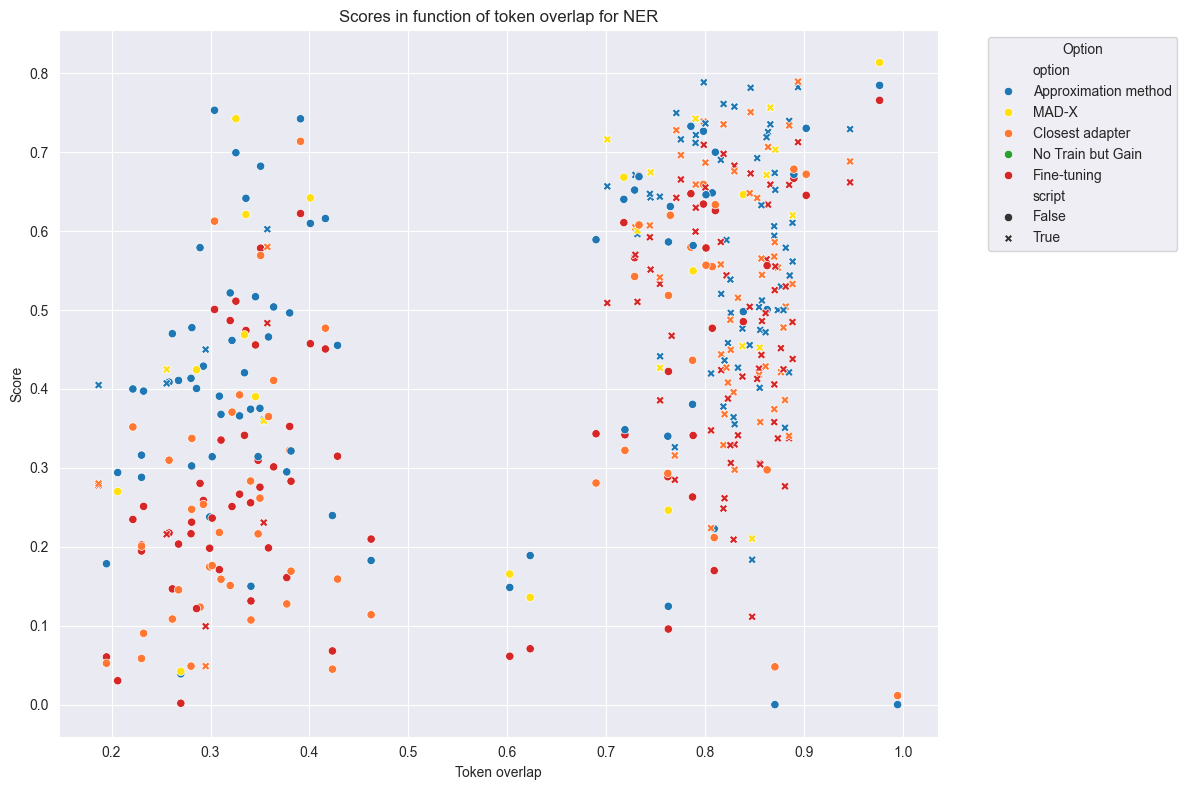

In [41]:
task_df = df_subset[df_subset["task"] == "ner"]
# we map the lang2script_bin to the dataframe entries that have missing values
task_df["script"] = task_df["lang"].map(lang2script_strict)
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=task_df, x="token_coverage", y="score", hue="option", hue_order=METHODS, palette=PALETTE, style="script"
)
plt.title("Scores in function of token overlap for NER")
plt.xlabel("Token overlap")
plt.ylabel("Score")
plt.legend(title="Option", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig("../output/ner_token_overlap.pdf", dpi=1000)

C:\Users\stefa\AppData\Local\Temp\ipykernel_48396\3951240301.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  task_df["Latin script"] = task_df["script"] == "Latn"


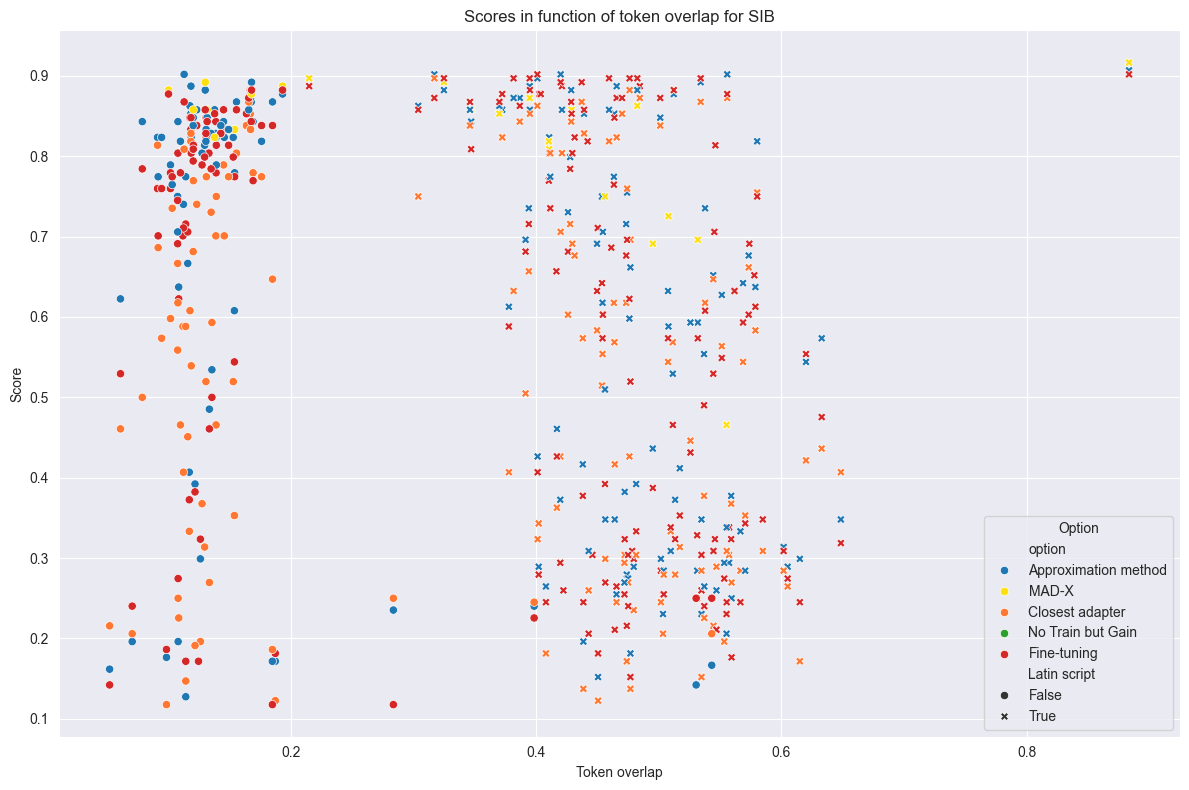

In [90]:
task = "sib"
task_df = df_subset[df_subset["task"] == task]
# we make a "script_vis" column that is True if the script is Latn, and False otherwise
task_df["Latin script"] = task_df["script"] == "Latn"
# we map the lang2script_bin to the dataframe entries that have missing values
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=task_df, x="token_coverage", y="score", hue="option", hue_order=METHODS, palette=PALETTE, style="Latin script"
)
plt.title(f"Scores in function of token overlap for {task.upper()}")
plt.xlabel("Token overlap")
plt.ylabel("Score")
plt.legend(title="Option")
plt.tight_layout()
plt.savefig(f"../output/{task}_token_overlap.pdf", dpi=1000)

In [7]:
# we check the lowest baseline_en scores, print their languages and their token overlap
lowest_baseline_en = []
for task_name in scores:
    for lang_name in scores[task_name]:
        if "baseline_en" in scores[task_name][lang_name]:
            baseline_en_score = scores[task_name][lang_name]["baseline_en"]
            if task_name == "qa":
                baseline_en_score /= 100  # adjust for qa
            lowest_baseline_en.append((task_name, lang_name, baseline_en_score))
lowest_baseline_en.sort(key=lambda x: x[2])
for task_name, lang_name, score in lowest_baseline_en[:10]:  # print the 10 lowest scores
    token_coverage = token_overlap[task_name][lang_name]["token_coverage"]
    type_overlap = token_overlap[task_name][lang_name]["type_overlap"]
    print(
        f"Task: {task_name}, Language: {lang_name}, Baseline EN Score: {score}, Token Coverage: {token_coverage}, Type Overlap: {type_overlap}"
    )

Task: ner, Language: bo, Baseline EN Score: 0.0, Token Coverage: 0.8702397743300423, Type Overlap: 0.8888888888888888
Task: ner, Language: dv, Baseline EN Score: 0.0, Token Coverage: 0.9941972920696325, Type Overlap: 0.9142857142857143
Task: qa, Language: ar, Baseline EN Score: 0.006463741447356786, Token Coverage: 0.24416004653783926, Type Overlap: 0.1368202286110149
Task: qa, Language: zh, Baseline EN Score: 0.006556876083766825, Token Coverage: 0.3627623185726172, Type Overlap: 0.22265246853823814
Task: qa, Language: tr, Baseline EN Score: 0.006730734994589465, Token Coverage: 0.5802767485458056, Type Overlap: 0.5378106111484218
Task: qa, Language: hi, Baseline EN Score: 0.006752093847257739, Token Coverage: 0.12968266187665725, Type Overlap: 0.18704710144927536
Task: qa, Language: th, Baseline EN Score: 0.006898950862396228, Token Coverage: 0.15087134981274508, Type Overlap: 0.2709302325581395
Task: qa, Language: el, Baseline EN Score: 0.007138273122905983, Token Coverage: 0.436979

# Analysis with sib

In [59]:
# we look at the languages that have more than one script
sib_multiple_scripts = {k: v for k, v in sib_overlap.items() if len(v) > 1}
sib_multiple_scripts_Latn = {k: v for k, v in sib_multiple_scripts.items() if "Latn" in v.keys()}
df_multiple_scripts = df[(df["lang"].isin(sib_multiple_scripts.keys())) & (df["task"] == "sib")]
# we compare the scores of the different scripts for the same language
df_multiple_scripts_Latn = df[(df["lang"].isin(sib_multiple_scripts_Latn.keys())) & (df["task"] == "sib")]
df_multiple_scripts_Latn

,task,lang,script,score,token_coverage,type_overlap,option
4064,sib,ace,Arab,0.161765,0.187424,0.033948,reconstructed_featural_base
4065,sib,ace,Arab,0.171569,0.187424,0.033948,reconstructed_syntactic_distVar
4066,sib,ace,Arab,0.171569,0.187424,0.033948,reconstructed_morphological_distVar
4067,sib,ace,Arab,0.171569,0.187424,0.033948,reconstructed_featural_eu
4068,sib,ace,Arab,0.171569,0.187424,0.033948,reconstructed_featural
...,...,...,...,...,...,...,...
7029,sib,taq,Tfng,0.250000,0.398470,0.526596,reconstructed_featural_sr
7030,sib,taq,Tfng,0.240196,0.398470,0.526596,reconstructed_featural_threshold
7031,sib,taq,Tfng,0.259804,0.398470,0.526596,reconstructed_morphological_threshold
7032,sib,taq,Tfng,0.235294,0.398470,0.526596,reconstructed_syntactic_threshold


In [60]:
# for Reconstructed_feautral, baseline_en, finetune, no_train_gain and closest_featural, we look at the difference
# we check for each Latn entry for a language, if there is another entry
# with the same language but a different script, and if so, we compute the difference
def compute_script_differences(df, option1):
    differences = []
    for lang in df["lang"].unique():
        lang_df = df[df["lang"] == lang]
        if len(lang_df) < 2:
            continue  # skip languages with only one script
        latn_score = lang_df[(lang_df["script"] == "Latn") & (lang_df["option"] == option1)]["score"].values
        other_scores = lang_df[(lang_df["script"] != "Latn") & (lang_df["option"] == option1)]["score"].values
        print(f"Language: {lang}, Latn score: {latn_score}, Other scores: {other_scores}")
        if len(latn_score) > 0 and len(other_scores) > 0:
            for other_score in other_scores:
                differences.append(latn_score[0] - other_score)
    return differences

In [64]:
to_check = ["reconstructed_featural", "baseline_en", "finetune", "no_train_gain", "baseline_closest_featural"]
for option in to_check:
    print("~~" * 20, f"\nChecking differences for {option}\n", "~~" * 20)
    differences = compute_script_differences(df_multiple_scripts_Latn, option)
    print(f"Differences for {option}: {differences}")
    print(f"Mean difference for {option}: {np.mean(differences)}")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
Checking differences for reconstructed_featural
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Language: ace, Latn score: [0.66176471], Other scores: [0.17156863]
Language: arb, Latn score: [0.29901961], Other scores: [0.85294118]
Language: bjn, Latn score: [], Other scores: []
Language: knc, Latn score: [0.30882353], Other scores: [0.16176471]
Language: min, Latn score: [0.75], Other scores: [0.12745098]
Language: taq, Latn score: [0.34803922], Other scores: [0.24019608]
Differences for reconstructed_featural: [np.float64(0.49019607843137253), np.float64(-0.553921568627451), np.float64(0.14705882352941177), np.float64(0.6225490196078431), np.float64(0.10784313725490194)]
Mean difference for reconstructed_featural: 0.16274509803921566
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
Checking differences for baseline_en
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Language: ace, Latn score: [0.6127451], Other scores: [0.1127451]
Language: arb, Latn score: [0.2

## Result:
When a Latin and Non-Latin version of the same language are available, our method scores, on average 16% higher on the Latin script variant. Comparable for finetune, baseline en and no train gain methods: no statistical difference to be found, as the sample is also small (only 5 languages where we can compare Latin and non-latin script).


In [80]:
# we transform df: the "option" column values become columns, with the scores as values
df_wide = df.pivot_table(
    index=["task", "lang", "script", "token_coverage", "type_overlap"], columns="option", values="score"
).reset_index()
# we drop entries with NaN values
df_wide = df_wide.dropna(
    subset=["reconstructed_featural", "baseline_en", "finetune", "no_train_gain", "baseline_closest_featural"]
)
df_wide

option,task,lang,script,token_coverage,type_overlap,baseline_avg_adapter,baseline_closest_featural,baseline_en,baseline_task_adapter,finetune,...,reconstructed_featural_eu,reconstructed_featural_limit,reconstructed_featural_sr,reconstructed_featural_threshold,reconstructed_morphological_distVar,reconstructed_morphological_limit,reconstructed_morphological_threshold,reconstructed_syntactic_distVar,reconstructed_syntactic_limit,reconstructed_syntactic_threshold
0,sib,ace,Arab,0.187424,0.033948,0.102941,0.122549,0.112745,0.176471,0.181373,...,0.171569,0.147059,0.171569,0.166667,0.171569,0.142157,0.151961,0.171569,0.161765,0.166667
1,sib,ace,Latn,0.476971,0.278240,0.450980,0.696078,0.612745,0.656863,0.519608,...,0.661765,0.686275,0.666667,0.661765,0.666667,0.691176,0.691176,0.666667,0.691176,0.686275
2,sib,acm,Arab,0.123347,0.026904,0.759804,0.740196,0.769608,0.828431,0.838235,...,0.857843,0.852941,0.852941,0.862745,0.852941,0.852941,0.852941,0.857843,0.852941,0.862745
4,sib,aeb,Arab,0.118857,0.027861,0.686275,0.539216,0.700980,0.769608,0.803922,...,0.823529,0.808824,0.828431,0.823529,0.823529,0.823529,0.823529,0.823529,0.808824,0.823529
5,sib,af,Latn,0.501310,0.270481,0.803922,0.838235,0.843137,0.848039,0.872549,...,0.843137,0.852941,0.843137,0.848039,0.848039,0.848039,0.848039,0.848039,0.852941,0.848039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,sib,yue,Hant,0.165758,0.033898,0.818627,0.867647,0.833333,0.848039,0.872549,...,0.857843,0.862745,0.857843,0.857843,0.857843,0.862745,0.862745,0.857843,0.872549,0.857843
199,sib,zh,Hans,0.193334,0.049352,0.843137,0.887255,0.862745,0.877451,0.882353,...,0.882353,0.882353,0.877451,0.877451,0.882353,0.887255,0.887255,0.882353,0.877451,0.872549
200,sib,zh,Hant,0.168052,0.030344,0.838235,0.877451,0.882353,0.882353,0.882353,...,0.892157,0.887255,0.892157,0.892157,0.892157,0.897059,0.897059,0.892157,0.887255,0.892157
201,sib,zsm,Latn,0.317101,0.198163,0.857843,0.897059,0.862745,0.901961,0.872549,...,0.892157,0.901961,0.892157,0.911765,0.901961,0.867647,0.892157,0.911765,0.906863,0.901961


In [82]:
# we do an OLS analysis to check for the effect of token overlap on SIB
import statsmodels.api as sm

X = df_wide[["token_coverage"]]
X = sm.add_constant(X)  # adds the intercept term
y = df_wide["reconstructed_featural"]
model = sm.OLS(y, X).fit()
print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     reconstructed_featural   R-squared:                       0.120
Model:                                OLS   Adj. R-squared:                  0.115
Method:                     Least Squares   F-statistic:                     24.58
Date:                    Mon, 02 Jun 2025   Prob (F-statistic):           1.63e-06
Time:                            22:26:09   Log-Likelihood:                 3.6183
No. Observations:                     183   AIC:                            -3.237
Df Residuals:                         181   BIC:                             3.182
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
cons

We see a NEGATIVE effect of token coverage: the lower the token overlap, the higher the scores are.


In [83]:
df_wide["improvement_madx"] = df_wide["reconstructed_featural"] - df_wide["baseline_closest_featural"]
df_wide["improvement_finetune"] = df_wide["reconstructed_featural"] - df_wide["finetune"]
df_wide["improvement_no_train_gain"] = df_wide["reconstructed_featural"] - df_wide["no_train_gain"]

X = df_wide[["token_coverage"]]
X = sm.add_constant(X)  # adds the intercept term
y = df_wide["improvement_madx"]
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       improvement_madx   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     22.51
Date:                Mon, 02 Jun 2025   Prob (F-statistic):           4.23e-06
Time:                        22:26:55   Log-Likelihood:                 149.50
No. Observations:                 183   AIC:                            -295.0
Df Residuals:                     181   BIC:                            -288.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.1374      0.017      8.

In [85]:
X = df_wide[["token_coverage"]]
X = sm.add_constant(X)  # adds the intercept term
y = df_wide["improvement_no_train_gain"]
model = sm.OLS(y, X).fit()
print(model.summary())

                                OLS Regression Results                               
Dep. Variable:     improvement_no_train_gain   R-squared:                       0.041
Model:                                   OLS   Adj. R-squared:                  0.036
Method:                        Least Squares   F-statistic:                     7.792
Date:                       Mon, 02 Jun 2025   Prob (F-statistic):            0.00581
Time:                               22:28:40   Log-Likelihood:                 407.21
No. Observations:                        183   AIC:                            -810.4
Df Residuals:                            181   BIC:                            -804.0
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------